Changed working directory to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_Copy/daily
Files: ['binary_mask8640.tif', 'binary_mask4180.tif', 'binary_mask9000.tif', 'binary_mask6172.tif', 'binary_mask7732.tif', 'binary_mask7044.tif', 'binary_mask6604.tif', 'binary_mask9776.tif', 'binary_mask32.tif', 'binary_mask8136.tif', 'binary_mask4468.tif', 'binary_mask1336.tif', 'binary_mask5228.tif', 'binary_mask2584.tif', 'binary_mask1440.tif', 'binary_mask1832.tif', 'binary_mask7488.tif', 'binary_mask3596.tif', 'binary_mask5808.tif', 'binary_mask8988.tif', 'binary_mask1916.tif', 'binary_mask1564.tif', 'binary_mask1212.tif', 'binary_mask708.tif', 'binary_mask596.tif', 'binary_mask7160.tif', 'binary_mask6720.tif', 'binary_mask9652.tif', 'binary_mask5192.tif', 'binary_mask8012.tif', 'binary_mask8764.tif', 'binary_mask9124.tif', 'binary_mask6056.tif', 'binary_mask3708.tif', 'binary_mask2148.tif', 'binary_mask7616.tif', 'binary_mask3236.tif', 'binary_mask6568.tif', 'binary_mask7

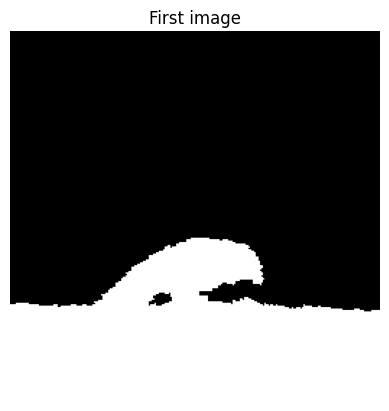

Width: 256
Height: 256
Image: (256, 256)
Loaded wave data shape: (9800, 3)


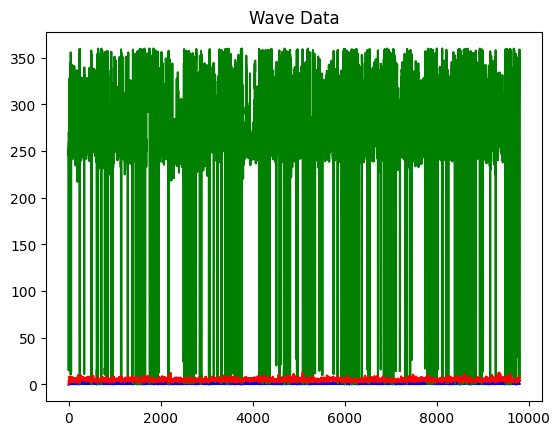

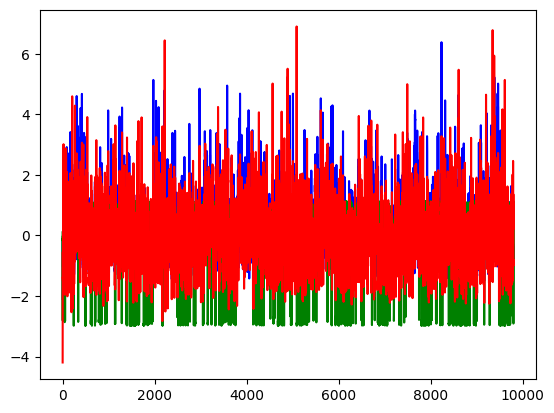

Loaded wave data shape: (9800, 3)


In [86]:
import os
import sys
from PIL import Image

def normalize_images(images):
    """Normalize each image to range [0, 1]"""
    images = images.astype(np.float32)
    max_val = np.max(images)
    if max_val > 0:
        images = images / max_val
    return images

def normalize_wave(wave_data):
    """
    Normalize each wave feature (Hs, Dir, Period) using standard score:
    z = (x - mean) / std
    Returns normalized data and stats for possible denormalization.
    """
    wave_data = wave_data.astype(np.float32)
    mean = wave_data.mean(axis=0)     # shape (3,)
    std = wave_data.std(axis=0) + 1e-8  # prevent division by zero
    normalized = (wave_data - mean) / std
    return normalized, mean, std

### LOAD FILES ###

path = r"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_Copy/daily/"
os.chdir(path)  # Change working directory
sys.path.append(path)  # Add to Python path if needed
print("Changed working directory to:", os.getcwd())
# List the files in the folder
print("Files:", os.listdir(path))

import glob
import numpy as np
import rasterio
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from torch.utils.data import Subset

tiff_files = sorted(glob.glob(f'{path}/binary_mask*.tif'),
                    key=lambda x: int(x.split('binary_mask')[-1].split('.tif')[0]))

#print number of files
print("Number of files:", len(tiff_files))

images = []
for file in tiff_files:
    img = Image.open(file)
    img_array = np.array(img)  # Convert to NumPy array
    images.append(img_array)

import matplotlib.pyplot as plt
plt.imshow(images[0], origin="lower",cmap='gray')
plt.title("First image")
plt.axis('off')
plt.show()

#print witdth and height
print("Width:", images[0].shape[1])
print("Height:", images[0].shape[0])
print("Image:", images[0].shape)
# 2. Load the wave data
wave_df = pd.read_csv(f'{path}time_series_data.csv')
wave_raw = wave_df[['Hs', 'Direction', 'Period']].values

print("Loaded wave data shape:", wave_raw.shape)

#plot Hs 
plt.plot(wave_raw[:, 0], label="Hs", color="blue")  # Significant wave height
plt.plot(wave_raw[:, 1], label="Direction", color="green")  # Wave direction
plt.plot(wave_raw[:, 2], label="Period", color="red")  # Wave period

plt.title("Wave Data")
plt.show()

wave_data, wave_mean, wave_std = normalize_wave(wave_raw)  # Shape: (num_days, 3)

#plot normalized Hs
plt.plot(wave_data[:, 0], label="Hs", color="blue")  # Significant wave height
plt.plot(wave_data[:, 1], label="Direction", color="green")  # Wave direction
plt.plot(wave_data[:, 2], label="Period", color="red")  # Wave period

plt.show()

print("Loaded wave data shape:", wave_data.shape)

In [92]:

time_step = os.path.basename(os.path.normpath(path))
print(time_step) 
output_freq = 2 # Frequency of output data in hours, 1: 1 hour, 2: 2 hours, 3: 3 hours, etc.


time_dict = {
    'daily': 8,
    'weekly': 40,
    'bi-monthly': 120,
    'monthly': 240,
}

#divide time_dict by output_freq
for key in time_dict.keys():
    time_dict[key] = time_dict[key] // output_freq

# Get the number of days from the time step
step = time_dict.get(time_step, 0)
print("Time step:", step)
print("Loaded images shape:", images[0].shape)
# Convert list to numpy array with shape (num_days, height, width)
images = np.array(images)
print("Loaded images shape:", images.shape)
images = normalize_images(images)
# Optionally add a channel dimension if your model expects one:
images = np.expand_dims(images, axis=1)  # Now shape: (num_days, 1, height, width)

print("Loaded images shape:", images.shape)

# Split by num_days BEFORE creating sliding windows
i = images.shape[0]
train_images = int(0.7 * i)
val_images = int(0.15 * i)
test_images = val_images

print("Train images:", train_images)
print("Validation images:", val_images)
print("Test images:", test_images)
print("Total images:", i)

train = images[:train_images]
val = images[train_images:train_images + val_images]
test = images[train_images + val_images:train_images + val_images + test_images]

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)

# For wave_data, which is hourly (24x more):
train_wave = wave_data[:train_images * step]
val_wave = wave_data[train_images * step:(train_images + val_images) * step]
test_wave = wave_data[(train_images + val_images) * step:(test_images+train_images+val_images) * step]

print("Train wave shape:", train_wave.shape)
print("Validation wave shape:", val_wave.shape)
print("Test wave shape:", test_wave.shape)


daily
Time step: 4
Loaded images shape: (1, 1, 1, 256, 256)
Loaded images shape: (2452, 1, 1, 1, 256, 256)
Loaded images shape: (2452, 1, 1, 1, 1, 256, 256)
Train images: 1716
Validation images: 367
Test images: 367
Total images: 2452
Train shape: (1716, 1, 1, 1, 1, 256, 256)
Validation shape: (367, 1, 1, 1, 1, 256, 256)
Test shape: (367, 1, 1, 1, 1, 256, 256)
Train wave shape: (6864, 3)
Validation wave shape: (1468, 3)
Test wave shape: (1468, 3)


In [93]:
def create_sequences(img_data, wave_data, input_length=10, target_length=10):
    seq_length = input_length + target_length
    num_days = img_data.shape[0]
    
    img_input, img_target, wave_input, wave_target = [], [], [], []

    for i in range(num_days - seq_length + 1):
        input_seq = img_data[i : i + input_length]
        target_seq = img_data[i + input_length : i + seq_length]
        
        wave_start = i * step
        wave_end = (i + input_length) * step
        wave_seq = wave_data[wave_start : wave_end]
        wave_future_seq = wave_data[wave_end : wave_end + (target_length * step)]

        img_input.append(input_seq)
        img_target.append(target_seq)
        wave_input.append(wave_seq)
        wave_target.append(wave_future_seq)

    return (
        torch.tensor(np.array(img_input), dtype=torch.float32),
        torch.tensor(np.array(img_target), dtype=torch.float32),
        torch.tensor(np.array(wave_input), dtype=torch.float32),
        torch.tensor(np.array(wave_target), dtype=torch.float32)
    )


In [ ]:
train_input, train_target, train_wave, train_wave_future = create_sequences(train, train_wave)
val_input, val_target, val_wave, val_wave_future = create_sequences(val, val_wave)
test_input, test_target, test_wave, test_wave_future = create_sequences(test, test_wave)

print(train_input.shape)
print(train_target.shape)
print(train_wave.shape)
print(train_wave_future.shape)

In [46]:
train_dataset = TensorDataset(train_input, train_target, train_wave, train_wave_future)
val_dataset = TensorDataset(val_input, val_target, val_wave, val_wave_future)
test_dataset = TensorDataset(test_input, test_target, test_wave, test_wave_future)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


NameError: name 'train_dataset' is not defined

In [92]:
## Final DataLoader

import os
from collections import defaultdict

def extract_index(filename):
        base = os.path.basename(filename)
        number = ''.join(filter(str.isdigit, base))
        return int(number) if number else -1

def load_tiff_images(tiff_folder):
    # Load the TIFF images

    tiff_files = glob.glob(os.path.join(tiff_folder, "binary_mask*.tif"))

    tiff_files = sorted(tiff_files, key=extract_index)

    if len(tiff_files) == 0:
        raise ValueError(f"No TIFF files found in folder: {tiff_folder}")

    images = []
    for file in tiff_files:
        img = Image.open(file)
        img_array = np.array(img)  # Convert to NumPy array
        images.append(img_array)
    

    # Convert list to numpy array with shape (num_days, height, width)
    images = np.array(images)
    images = normalize_images(images)
    images = np.expand_dims(images, axis=1)  # Now shape: (num_days, 1, height, width)
    return images

def normalize_images(images):
    """Normalize each image to range [0, 1]"""
    images = images.astype(np.float32)
    max_val = np.max(images)
    if max_val > 0:
        images = images / max_val
    return images

def normalize_wave(wave_data):
    """
    Normalize each wave feature (Hs, Dir, Period) using standard score:
    z = (x - mean) / std
    Returns normalized data and stats for possible denormalization.
    """
    wave_data = wave_data.astype(np.float32)
    mean = wave_data.mean(axis=0)     # shape (3,)
    std = wave_data.std(axis=0) + 1e-8  # prevent division by zero
    normalized = (wave_data - mean) / std
    return normalized, mean, std

def load_wave_data(path):
    csv_path = os.path.join(path, 'time_series_data.csv')
    wave_df = pd.read_csv(csv_path)
    return wave_df[['Hs', 'Direction', 'Period']].values  # Shape: (num_days, 3)

def create_sequences(img_data, wave_data, step, input_length=10, target_length=10):
    seq_length = input_length + target_length
    num_days = img_data.shape[0]
    
    img_input, img_target, wave_input, wave_target = [], [], [], []

    for i in range(num_days - seq_length + 1):
        input_seq = img_data[i : i + input_length]
        target_seq = img_data[i + input_length : i + seq_length]
        
        wave_start = i * step
        wave_end = (i + input_length) * step
        wave_seq = wave_data[wave_start : wave_end]
        wave_future_seq = wave_data[wave_end : wave_end + (target_length * step)]

        img_input.append(input_seq)
        img_target.append(target_seq)
        wave_input.append(wave_seq)
        wave_target.append(wave_future_seq)

    return (
        torch.tensor(np.array(img_input), dtype=torch.float32),
        torch.tensor(np.array(img_target), dtype=torch.float32),
        torch.tensor(np.array(wave_input), dtype=torch.float32),
        torch.tensor(np.array(wave_target), dtype=torch.float32)
    )



output_freq = 2  # Frequency of output data in hours
time_dict = {
    #'daily': 4,
    'weekly': 34,
    'bi-monthly': 72,
    'monthly': 144,
}
case=1
time="bi-monthly"

main_dir = r"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/"
cases = {
    1: ["v0_1", "v1_1", "v2_1", "v3_1", "v4_1", "v5_1", "v6_1", "v7_1", "v8_1"],
}
#case = 1
#time = "weekly"
step = time_dict[time] // output_freq
scenario = cases.get(case, [])

# Match folders that end with one of the version tags
scenario_folders = [
    folder for folder in os.listdir(main_dir)
    if os.path.isdir(os.path.join(main_dir, folder)) and any(folder.endswith(v) for v in scenario)
]

print("Matching folders:", scenario_folders)
data_loaders = {}

for data_type in ["training", "validation", "testing"]:
    img_inputs = []
    img_targets = []
    wave_inputs = []
    wave_targets = []

    for folder in scenario_folders:
        dir_path = os.path.join(main_dir, folder, time, data_type)

        try:

            images = load_tiff_images(dir_path)
            waves = load_wave_data(dir_path)
            wave_data, _, _ = normalize_wave(waves)

            img_input, img_target, wave_input, wave_future = create_sequences(images, wave_data, step)

            img_inputs.append(img_input)
            img_targets.append(img_target)
            wave_inputs.append(wave_input)
            wave_targets.append(wave_future)

        except ValueError as e:
            print(f"Error loading data from {dir_path}: {e}")
            continue

        



    # Concatenate all tensors for this data_type
    img_input = torch.cat(img_inputs, dim=0)
    img_target = torch.cat(img_targets, dim=0)
    wave_input = torch.cat(wave_inputs, dim=0)
    wave_future = torch.cat(wave_targets, dim=0)

    print("Train input shape:", img_input.shape)
    print("Train target shape:", img_target.shape)
    print("Train wave input shape:", wave_input.shape)
    print("Train wave future shape:", wave_future.shape)
    # Create dataset and dataloader
    dataset = TensorDataset(img_input, img_target, wave_input, wave_future)
    shuffle = data_type == "training"
    loader = DataLoader(dataset, batch_size=8, shuffle=shuffle)

    data_loaders[data_type] = loader

train_loader = data_loaders["training"]
val_loader = data_loaders["validation"]
test_loader = data_loaders["testing"]





Matching folders: ['zm_fromBart_v8_1', 'zm_fromBart_v2_1', 'zm_fromBart_v3_1', 'zm_fromBart_v1_1', 'zm_fromBart_v0_1', 'zm_fromBart_v4_1', 'zm_fromBart_v5_1', 'zm_fromBart_v7_1', 'zm_fromBart_v6_1']
Error loading data from /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/bi-monthly/training: No TIFF files found in folder: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/bi-monthly/training
Train input shape: torch.Size([200, 10, 1, 256, 256])
Train target shape: torch.Size([200, 10, 1, 256, 256])
Train wave input shape: torch.Size([200, 360, 3])
Train wave future shape: torch.Size([200, 360, 3])
Error loading data from /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/bi-monthly/validation: No TIFF files found in folder: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/bi-monthly/validation
Train input shape: torch.Size([72, 10, 1, 256, 256])
Train target shape: torch.Size([72, 10, 1, 256, 25

Input sequence shape: torch.Size([10, 1, 256, 256])
Target sequence shape: torch.Size([10, 1, 256, 256])
Wave sequence shape: torch.Size([360, 3])
Wave future sequence shape: torch.Size([360, 3])
First frame in input sequence, min: 0.0, max: 1.0
First wave data: tensor([-0.4620,  0.3300, -0.7457])


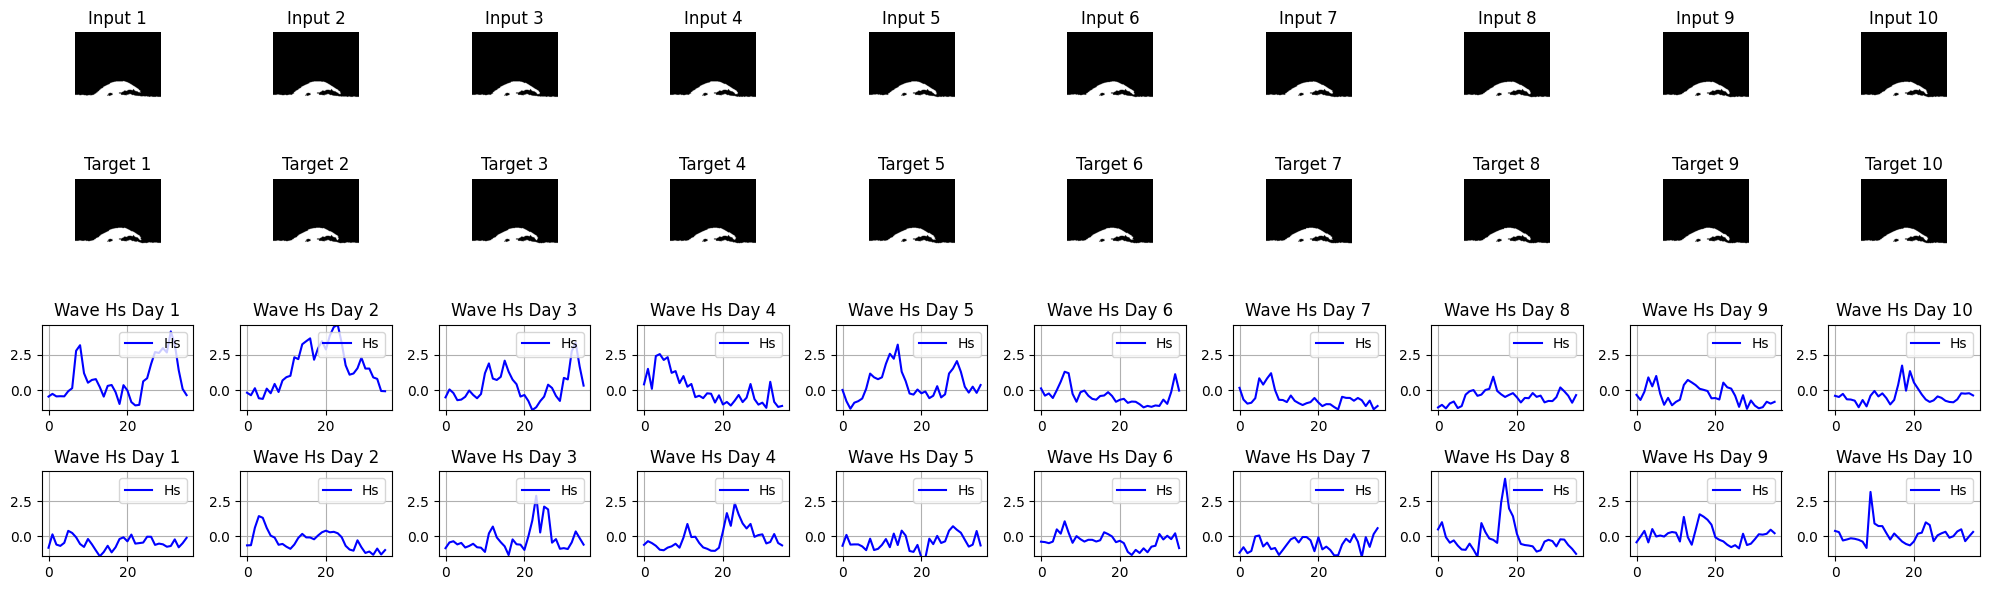

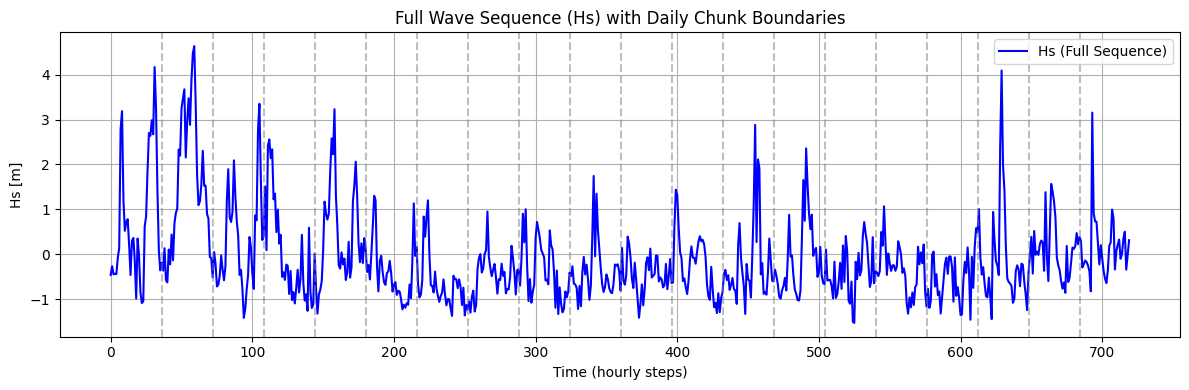

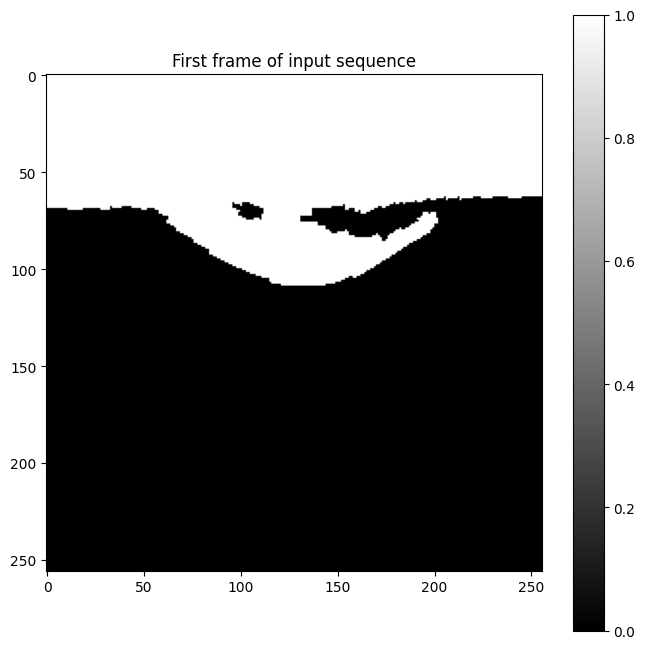

In [95]:
# Get a single sequence from the dataset (returns a tuple of tensors)
sample_idx = 10# Index of the sequence you want to view
input_seq, target_seq, wave_seq, wave_future_seq = test_loader.dataset[sample_idx]

# Print information about the tensors
print(f"Input sequence shape: {input_seq.shape}")
print(f"Target sequence shape: {target_seq.shape}")
print(f"Wave sequence shape: {wave_seq.shape}")
print(f"Wave future sequence shape: {wave_future_seq.shape}")

# Print a specific frame from the input sequence (first frame)
print(f"First frame in input sequence, min: {input_seq[0, 0].min()}, max: {input_seq[0, 0].max()}")

# If you want to see the actual values:
print(f"First wave data: {wave_seq[0]}")  # First timestep of wave data

# To visualize a specific frame without converting to numpy
import matplotlib.pyplot as plt

# Plotting function
def plot_sequence(input_seq, target_seq, wave_seq, wave_future_seq):
    num_images = input_seq.shape[0]  # Number of images in the sequence (10)
    fig, axes = plt.subplots(4, num_images, figsize=(20, 6))

    # Plot input images
    for i in range(num_images):
        ax = axes[0, i]
        ax.imshow(input_seq[i, 0], origin='lower', cmap='gray')  # Single channel (grayscale)
        ax.set_title(f"Input {i+1}")
        ax.axis('off')

    # Plot target images
    for i in range(num_images):
        ax = axes[1, i]
        ax.imshow(target_seq[i, 0], origin='lower', cmap='gray')  # Single channel (grayscale)
        ax.set_title(f"Target {i+1}")
        ax.axis('off')

    wave_seq_daily = wave_seq.reshape(10, step, 3)
    minimum = wave_seq_daily[:, :, 0].min()
    maximum = wave_seq_daily[:, :, 0].max()

    wave_seq_fut_daily = wave_future_seq.reshape(10, step, 3)
    
    # Plot wave data
    for i in range(num_images):
        ax = axes[2, i]
        ax.plot(wave_seq_daily[i, :, 0], label="Hs", color="blue")  # 24 hourly values of Hs
        ax.set_ylim(minimum, maximum)
        ax.set_title(f"Wave Hs Day {i+1}")
        ax.legend(loc="upper right")
        ax.grid()

    # Plot wave data
    for i in range(num_images):
        ax = axes[3, i]
        ax.plot(wave_seq_fut_daily[i, :, 0], label="Hs", color="blue")  # 24 hourly values of Hs
        ax.set_ylim(minimum, maximum)
        ax.set_title(f"Wave Hs Day {i+1}")
        ax.legend(loc="upper right")
        ax.grid()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_sequence(input_seq, target_seq, wave_seq, wave_future_seq)

# concat wave + future
hs_full = np.concatenate((wave_seq, wave_future_seq), axis=0)

plt.figure(figsize=(12, 4))
plt.plot(hs_full[:, 0], label='Hs (Full Sequence)', color='blue')

# Add vertical lines every 24 hours to show chunks
for i in range(1, 20):
    plt.axvline(x=i*step, color='gray', linestyle='--', alpha=0.5)
plt.title('Full Wave Sequence (Hs) with Daily Chunk Boundaries')
plt.xlabel('Time (hourly steps)')
plt.ylabel('Hs [m]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot the first frame from the input sequence
plt.figure(figsize=(8, 8))
plt.imshow(input_seq[2, 0], cmap='gray')  # [time_idx, channel_idx]
plt.title("First frame of input sequence")
plt.colorbar()
plt.show()

In [ ]:

path = r"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_Copy/weekly/"
os.chdir(path)  # Change working directory
sys.path.append(path)  # Add to Python path if needed


def normalize_images(images):
    """Normalize each image to range [0, 1]"""
    images = images.astype(np.float32)
    max_val = np.max(images)
    if max_val > 0:
        images = images / max_val
    return images

def normalize_wave(wave_data):
    """
    Normalize each wave feature (Hs, Dir, Period) using standard score:
    z = (x - mean) / std
    Returns normalized data and stats for possible denormalization.
    """
    wave_data = wave_data.astype(np.float32)
    mean = wave_data.mean(axis=0)     # shape (3,)
    std = wave_data.std(axis=0) + 1e-8  # prevent division by zero
    normalized = (wave_data - mean) / std
    return normalized, mean, std


def load_tiff_images(tiff_folder):
# 1. Load the TIFF images
# Assume your TIFF images are stored in a folder "tiff_folder" with names like "binary_mask0.tif"
    tiff_files = sorted(glob.glob(tiff_folder),
                        key=lambda x: int(x.split('binary_mask')[-1].split('.tif')[0]))

    images = []
    for file in tiff_files:
        img = Image.open(file)
        img_array = np.array(img)  # Convert to NumPy array
        images.append(img_array)


    # Convert list to numpy array with shape (num_days, height, width)
    images = np.array(images)
    images = normalize_images(images)
    images = np.expand_dims(images, axis=1)  # Now shape: (num_days, 1, height, width)
    return images

# 2. Load the wave data
def load_wave_data(csv_path):
    cvs_path = os.path.join(path, 'time_series_data.csv')
    wave_df = pd.read_csv(csv_path)
    return wave_df[['Hs', 'Direction', 'Period']].values  # Shape: (num_days, 3)




def get_dataloaders(path, batch_size, input_length=10, target_length=10):

    tiff_path = os.path.join(path, 'binary_mask*.tif')
    cvs_path = os.path.join(path, 'time_series_data.csv')

    time_step = os.path.basename(os.path.normpath(path))

    output_freq = 2 # Frequency of output data in hours, 1: 1 hour, 2: 2 hours, 3: 3 hours, etc.


    time_dict = {
        'daily': 8,
        'weekly': 40,
        'bi-monthly': 120,
        'monthly': 240,
    }

    #divide time_dict by output_freq
    for key in time_dict.keys():
        time_dict[key] = time_dict[key] // output_freq

    step = time_dict.get(time_step, 0)

    images = load_tiff_images(tiff_path)
    print("Loaded images shape:", images.shape)
    wave_data = load_wave_data(cvs_path)
    print("Loaded wave data shape:", wave_data.shape)
    wave_data, x, y = normalize_wave(wave_data)  # Normalize wave data

    #SPLIT DATA
    train, val, test, train_wave, val_wave, test_wave = split_data(images, wave_data, step)

    print("Train wave shape:", train_wave.shape)
    print("Validation wave shape:", val_wave.shape)
    print("Test wave shape:", test_wave.shape)
    print("Train wave shape:", train_wave.shape)
    print("Validation wave shape:", val_wave.shape)
    print("Test wave shape:", test_wave.shape)


    # Create sequences
    train_input, train_target, train_wave, train_wave_future = create_sequences(train, train_wave, step)
    val_input, val_target, val_wave, val_wave_future = create_sequences(val, val_wave, step)
    test_input, test_target, test_wave, test_wave_future = create_sequences(test, test_wave, step)

    print("Train input shape:", train_input.shape)
    print("Train target shape:", train_target.shape)
    print("Train wave shape:", train_wave.shape)
    print("Train wave future shape:", train_wave_future.shape)
    print("Validation input shape:", val_input.shape)
    print("Validation target shape:", val_target.shape)
    print("Validation wave shape:", val_wave.shape)
    print("Validation wave future shape:", val_wave_future.shape)
    print("Test input shape:", test_input.shape)
    print("Test target shape:", test_target.shape)
    print("Test wave shape:", test_wave.shape)
    print("Test wave future shape:", test_wave_future.shape)

    # Reshape the data to match the expected input shape
    train_dataset = TensorDataset(train_input, train_target, train_wave, train_wave_future)
    val_dataset = TensorDataset(val_input, val_target, val_wave, val_wave_future)
    test_dataset = TensorDataset(test_input, test_target, test_wave, test_wave_future)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader



In [66]:
#Load dataset

data_path = "/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_Copy/bi-monthly/"
train_loader, val_loader, test_loader = get_dataloaders(data_path, batch_size=8)

# Verify shapes
for inputs, targets, wave, wave_fut in train_loader:
    print("Train Inputs shape:", inputs.shape)  # Should be (B, T-10, 1, H, W)
    print("Train Targets shape:", targets.shape)  # Should be (B, 10, 1, H, W)
    print("Wave shape:", wave.shape)  # Should be (B, 480, 1)
    print("Wave shape:", wave_fut.shape)  # Should be (B, 240, 3)
    break

for inputs, targets, wave, wave_fut in val_loader:
    print("Validation Inputs shape:", inputs.shape)  # Should be (B, T-10, 1, H, W)
    print("Validation Targets shape:", targets.shape)  # Should be (B, 10, 1, H, W)
    print("Wave shape:", wave.shape)  # Should be (B, 480, 1)
    print("Wave shape:", wave_fut.shape)  # Should be (B, 240, 3)
    break

for inputs, targets, wave, wave_fut in test_loader:
    print("Test Inputs shape:", inputs.shape)  # Should be (B, T-10, 1, H, W)
    print("Test Targets shape:", targets.shape)  # Should be (B, 10, 1, H, W)
    print("Wave shape:", wave.shape)  # Should be (B, 480, 1)
    print("Wave shape:", wave_fut.shape)  # Should be (B, 240, 3)
    break

Loaded images shape: (164, 1, 256, 256)
Loaded wave data shape: (9800, 3)
Train images: 98
Validation images: 32
Test images: 33
Total images: 164
Train wave shape: (5880, 3)
Validation wave shape: (1920, 3)
Test wave shape: (1980, 3)
Train wave shape: (5880, 3)
Validation wave shape: (1920, 3)
Test wave shape: (1980, 3)
Train input shape: torch.Size([79, 10, 1, 256, 256])
Train target shape: torch.Size([79, 10, 1, 256, 256])
Train wave shape: torch.Size([79, 600, 3])
Train wave future shape: torch.Size([79, 600, 3])
Validation input shape: torch.Size([13, 10, 1, 256, 256])
Validation target shape: torch.Size([13, 10, 1, 256, 256])
Validation wave shape: torch.Size([13, 600, 3])
Validation wave future shape: torch.Size([13, 600, 3])
Test input shape: torch.Size([14, 10, 1, 256, 256])
Test target shape: torch.Size([14, 10, 1, 256, 256])
Test wave shape: torch.Size([14, 600, 3])
Test wave future shape: torch.Size([14, 600, 3])
Train Inputs shape: torch.Size([8, 10, 1, 256, 256])
Train Ta

Input sequence shape: torch.Size([10, 1, 256, 256])
Target sequence shape: torch.Size([10, 1, 256, 256])
Wave sequence shape: torch.Size([600, 3])
Wave future sequence shape: torch.Size([600, 3])


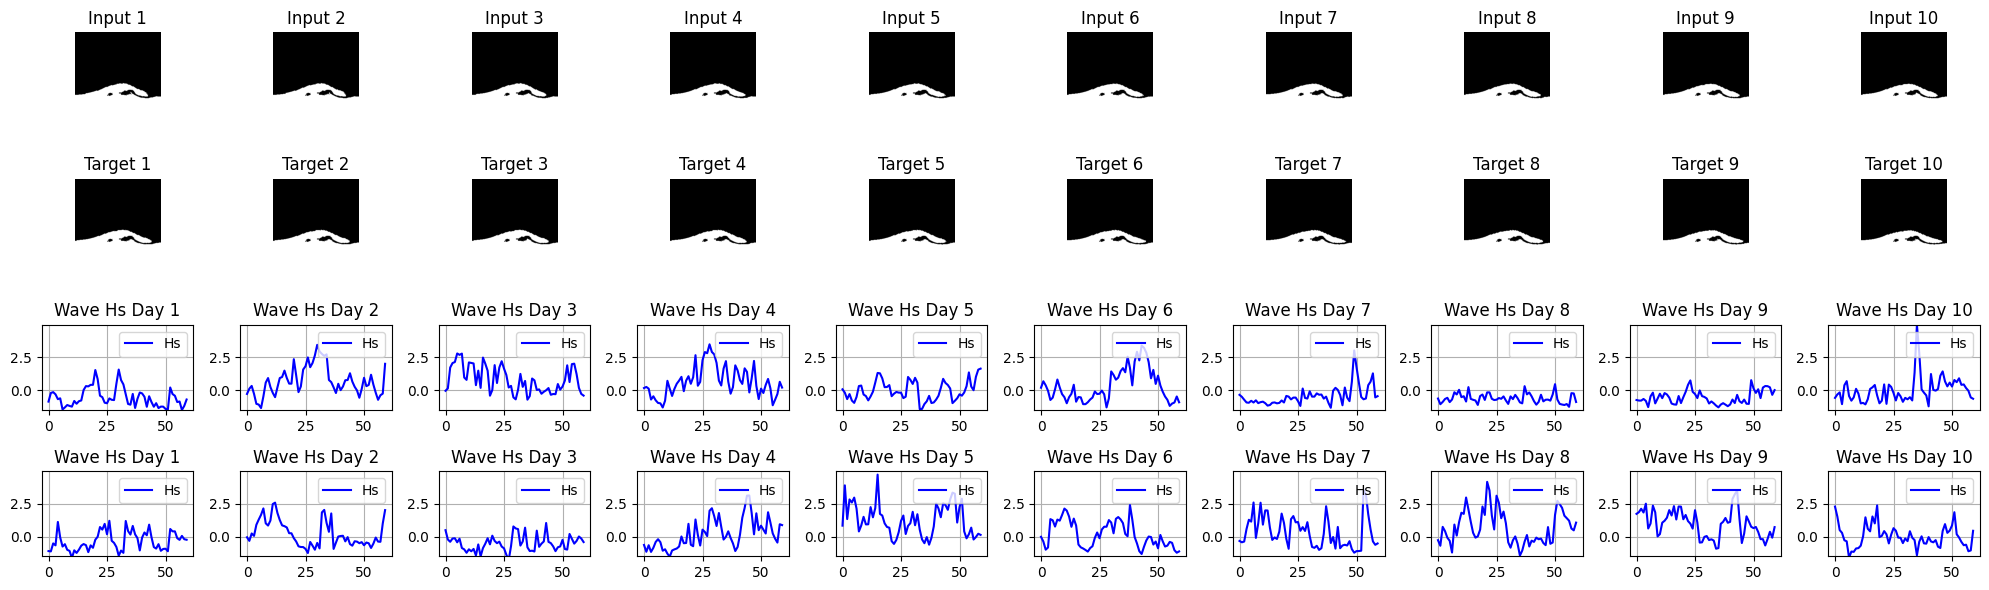

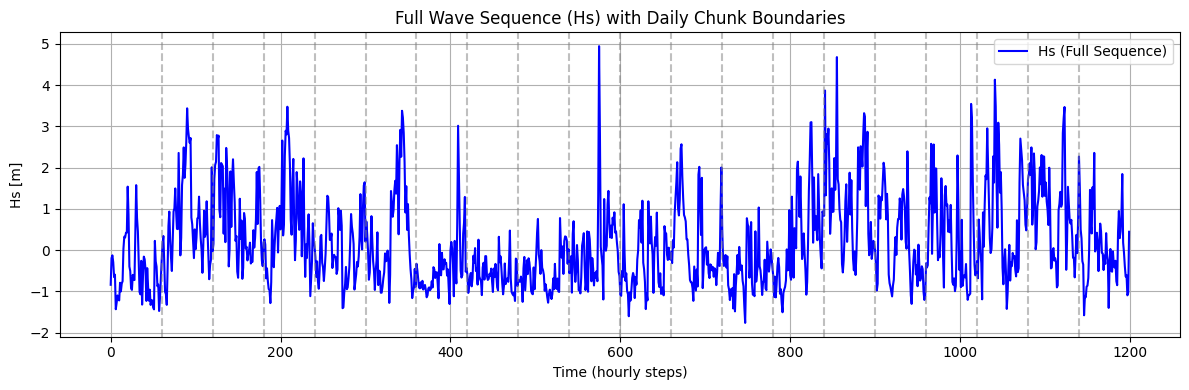

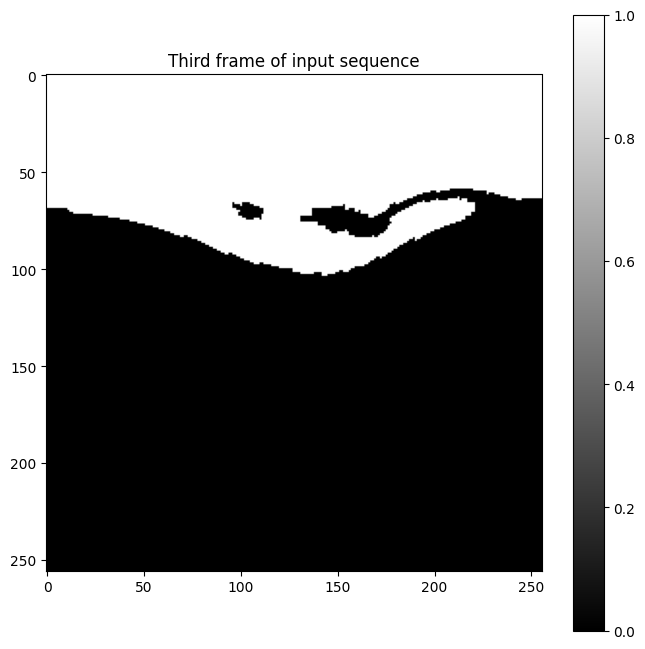

In [85]:
# Load one batch from the train_loader
batch = next(iter(train_loader))  # Get one batch (inputs, targets, wave, wave_fut)
input_seqs, target_seqs, wave_seqs, wave_future_seqs = batch

# Select one sample inside the batch
sample_idx = 0  # (you can change it to select another sample in the batch)

input_seq = input_seqs[sample_idx]         # Shape: (T-10, 1, H, W)
target_seq = target_seqs[sample_idx]        # Shape: (10, 1, H, W)
wave_seq = wave_seqs[sample_idx]            # Shape: (480, 1)
wave_future_seq = wave_future_seqs[sample_idx]  # Shape: (240, 3)

# Remove extra channel if needed
wave_seq = wave_seq.squeeze(-1)  # (480,)
# wave_future_seq might already have shape (240, 3)

print(f"Input sequence shape: {input_seq.shape}")
print(f"Target sequence shape: {target_seq.shape}")
print(f"Wave sequence shape: {wave_seq.shape}")
print(f"Wave future sequence shape: {wave_future_seq.shape}")

# Plot using your existing function
plot_sequence(input_seq, target_seq, wave_seq, wave_future_seq)

# Plot full wave sequence
hs_full = np.concatenate((wave_seq[:,0], wave_future_seq[:,0]), axis=0)  # wave_future_seq[:, 0] to get Hs

plt.figure(figsize=(12, 4))
plt.plot(hs_full, label='Hs (Full Sequence)', color='blue')

for i in range(1, 20):
    plt.axvline(x=i*step, color='gray', linestyle='--', alpha=0.5)
plt.title('Full Wave Sequence (Hs) with Daily Chunk Boundaries')
plt.xlabel('Time (hourly steps)')
plt.ylabel('Hs [m]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the third frame from the input sequence
plt.figure(figsize=(8, 8))
plt.imshow(input_seq[2, 0], cmap='gray')
plt.title("Third frame of input sequence")
plt.colorbar()
plt.show()
